# Audio Classifier

In [1]:
from visualization import *
from datasets import *
from utils import *
from models import *

## Vowels dataset

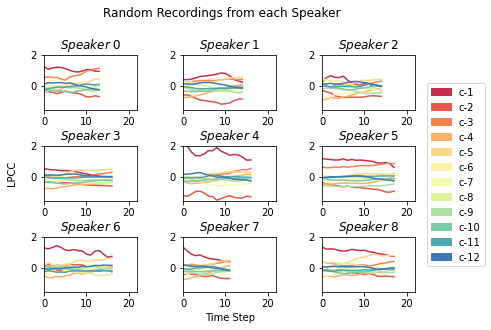

In [2]:
X_train_vowels, y_train_vowels, X_test_vowels, y_test_vowels = get_japanese_vowels()
plot_recordings(X_train_vowels)

Min length: 7 Max length: 26


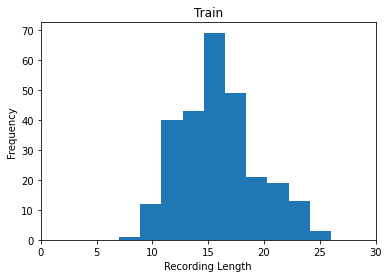

Min length: 7 Max length: 29


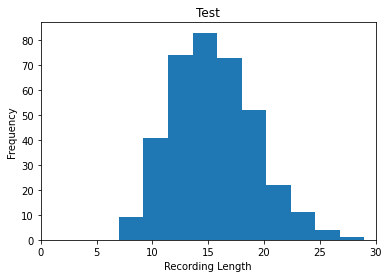

In [3]:
plot_rec_len_freq(X_train_vowels, "Train")
plot_rec_len_freq(X_test_vowels, "Test")

### CNN

In [4]:
X_train_vowels_uni, X_test_vowels_uni = pre_process(X_train_vowels, X_test_vowels, rec_len=30)
input_shape_vowels = (30, 12)

In [5]:
history, cnn_model = train_cnn_model(input_shape_vowels,
                                     X_train_vowels_uni, 
                                     y_train_vowels,
                                     X_test_vowels_uni,
                                     y_test_vowels)
plot_cnn_training(history)
eval_model(cnn_model, X_test_vowels_uni, y_test_vowels)

NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_2' defined at (most recent call last):
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 619, in start
      self.io_loop.start()
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 358, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 536, in execute_request
      self.do_execute(
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-5-b506ea7cfa65>", line 1, in <module>
      history, cnn_model = train_cnn_model(input_shape_vowels,
    File "/Users/otoz/Desktop/audio-classifier/models.py", line 58, in train_cnn_model
      history = cnn_model.fit(x=train_dataset,
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_2'
could not find registered platform with id: 0x133d5ce30
	 [[{{node StatefulPartitionedCall_2}}]] [Op:__inference_train_function_768]

### RF

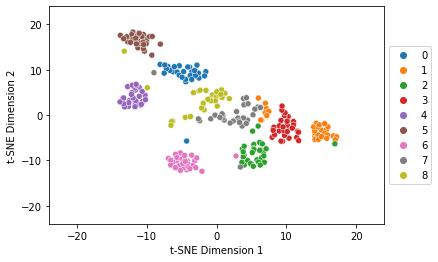

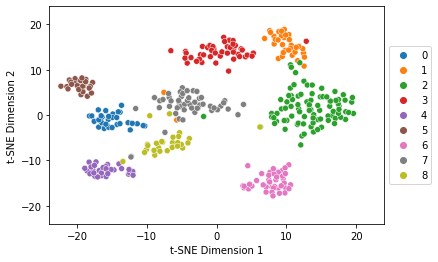

In [6]:
X_feat_train_vowels = extract_features(X_train_vowels_uni)
X_feat_test_vowels = extract_features(X_test_vowels_uni)
plot_tsne(X_feat_train_vowels, y_train_vowels)
plot_tsne(X_feat_test_vowels, y_test_vowels)

Accuracy 0.9783783783783784
F1-Score 0.9782804927223758


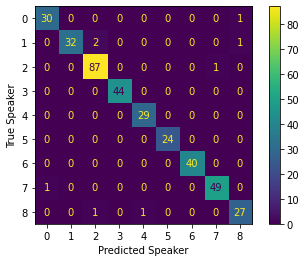

In [8]:
random_forest(X_feat_train_vowels, y_train_vowels, X_feat_test_vowels, y_test_vowels)

---

## Digits dataset

In [9]:
X_digits, y_digits_num, y_digits_speaker = get_spoken_digits()
X_train_digits, X_test_digits, y_train_digits, y_test_digits = train_test_split(X_digits, y_digits_speaker, test_size=0.5, stratify=y_digits_speaker)

Min length: 9 Max length: 152


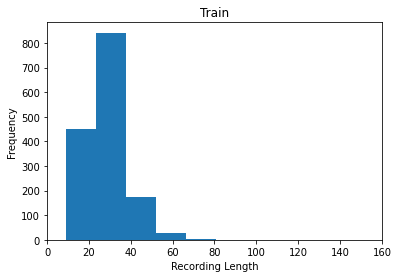

Min length: 9 Max length: 146


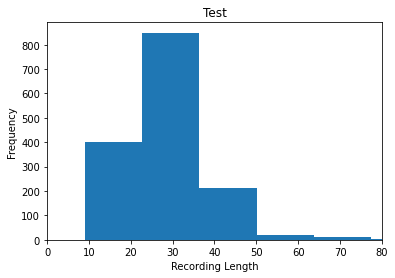

In [10]:
plot_rec_len_freq(X_train_digits, "Train", xmax=160)
plot_rec_len_freq(X_test_digits, "Test", xmax=80)

### CNN

In [11]:
X_train_digits_uni, X_test_digits_uni = pre_process(X_train_digits, X_test_digits, 50)
input_shape_digits = (50, 12)

In [12]:
history_digits, cnn_model_digits = train_cnn_model(input_shape_digits,
                                                   X_train_digits_uni, 
                                                   y_train_digits,
                                                   X_test_digits_uni,
                                                   y_test_digits)
plot_cnn_training(history_digits)
eval_model(cnn_model_digits, X_test_digits_uni, y_test_digits)

NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_2' defined at (most recent call last):
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 619, in start
      self.io_loop.start()
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 358, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 536, in execute_request
      self.do_execute(
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-12-2fdaac41c016>", line 1, in <module>
      history_digits, cnn_model_digits = train_cnn_model(input_shape_digits,
    File "/Users/otoz/Desktop/audio-classifier/models.py", line 58, in train_cnn_model
      history = cnn_model.fit(x=train_dataset,
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/Users/otoz/miniforge3/envs/pyenv38/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_2'
could not find registered platform with id: 0x133d5ce30
	 [[{{node StatefulPartitionedCall_2}}]] [Op:__inference_train_function_1535]

### RF

Accuracy 0.978
F1-Score 0.9779142613719368


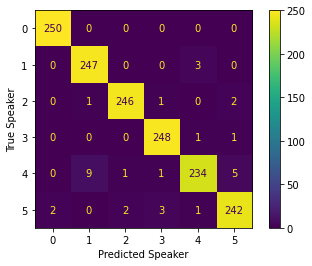

In [13]:
X_feat_train_digits = extract_features(X_train_digits_uni, n_windows=5)
X_feat_test_digits = extract_features(X_test_digits_uni, n_windows=5)

random_forest(X_feat_train_digits, y_train_digits, X_feat_test_digits, y_test_digits)